In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt

In [2]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [3]:
data_path = "/papers_2000/"

In [4]:
short_papers = spark.read.json("../data/processed/"+data_path+"/short_papers/")

In [5]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [6]:
from pyspark.sql.functions import split, lower, length, size, array_contains

In [7]:
common_words = list(
    spark.read.csv("../data/4000-most-common-english-words-csv.csv").withColumnRenamed("_c0", "K").toPandas()["K"]
)

In [8]:
kws  = short_papers.select(explode(split(col("abstract")," ")).alias("K")).withColumn("K",lower("K")).\
    filter( ~col("K").isin(common_words)).\
    filter(~col("K").contains("\\")).\
    filter(~col("K").isin(["is", "are", "an", "has"])).\
    filter(length(col("K"))>4)
kws_counts = kws.groupby("K").count().sort(desc("count"))
kws_counts.show(50)

+--------------+-----+
|             K|count|
+--------------+-----+
|      neutrino| 2168|
|         quark| 1695|
|       results| 1337|
|         decay| 1264|
|         higgs| 1205|
|         using| 1002|
|       effects|  931|
|        mixing|  922|
|         gauge|  879|
|        masses|  859|
|        chiral|  852|
|        models|  818|
|   corrections|  815|
|supersymmetric|  742|
|        scalar|  739|
|        decays|  717|
|    scattering|  709|
|      symmetry|  696|
|      obtained|  653|
|         shown|  630|
|     parameter|  619|
| contributions|  612|
|      coupling|  597|
|    parameters|  576|
|        values|  568|
|         based|  567|
|      breaking|  566|
|         gluon|  554|
|        matrix|  551|
|     neutrinos|  540|
|     functions|  533|
|   electroweak|  529|
|       quantum|  525|
|        model.|  518|
|         boson|  505|
|        lepton|  504|
|    discussed.|  499|
|        states|  487|
|         meson|  482|
|     asymmetry|  459|
|        ph

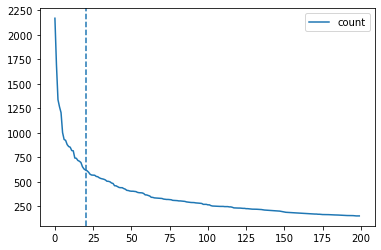

In [9]:
kws_counts.limit(200).select("count").toPandas().plot()
plt.axvline(20, linestyle = "--")

In [10]:
# replacing some characters with _
import re
def format_kwd(kwd):
    return re.sub("[\.-/ :()]", "_", kwd)

In [11]:
selected_keywords = kws_counts.limit(20).toPandas()["K"].tolist()
selected_keywords = [format_kwd(K) for K in selected_keywords] + ["None"]
#selected_keywords

In [12]:
# from https://www.geeksforgeeks.org/python-intersection-two-lists/
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
from pyspark.sql.functions import monotonically_increasing_id

Extracting these keywords to a column

In [13]:
# returns first keyword
#@udf(returnType=ArrayType(StringType()))
@udf(returnType=ArrayType(StringType()))
def filtered_list_keywords(a): 
    kws_list = [format_kwd(aa) for aa in a] if a else ["None"]
    kws_list = intersection(kws_list, selected_keywords)
    return kws_list if kws_list else ["None"]


In [14]:
withKeywords = short_papers.withColumn("abs", split(col("abstract"), " "))\
    .withColumn("keywords_", filtered_list_keywords(col("abs")))

In [15]:
dummy_df = withKeywords
for kw in selected_keywords:
    dummy_df = dummy_df.withColumn(
        kw.replace(".", "_"), 
        array_contains(col("keywords_"), kw).cast("int")
    )
dummy_df = dummy_df.select( ["title","number_of_pages", "citation_count", "num_refs"] + selected_keywords)
dummy_df = dummy_df.withColumn("id", monotonically_increasing_id())
dummy_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- citation_count: long (nullable = true)
 |-- num_refs: long (nullable = true)
 |-- neutrino: integer (nullable = true)
 |-- quark: integer (nullable = true)
 |-- results: integer (nullable = true)
 |-- decay: integer (nullable = true)
 |-- higgs: integer (nullable = true)
 |-- using: integer (nullable = true)
 |-- effects: integer (nullable = true)
 |-- mixing: integer (nullable = true)
 |-- gauge: integer (nullable = true)
 |-- masses: integer (nullable = true)
 |-- chiral: integer (nullable = true)
 |-- models: integer (nullable = true)
 |-- corrections: integer (nullable = true)
 |-- supersymmetric: integer (nullable = true)
 |-- scalar: integer (nullable = true)
 |-- decays: integer (nullable = true)
 |-- scattering: integer (nullable = true)
 |-- symmetry: integer (nullable = true)
 |-- obtained: integer (nullable = true)
 |-- shown: integer (nullable = true)
 |-- None: integer (nullable = t

In [16]:
dummy_df.write.mode("overwrite").json("../data/processed/"+data_path+"/abs/dummy/")